In [67]:
import cv2
import tensorflow as tf
import os

In [68]:
import collections
import numpy as np
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import six
import tensorflow as tf
from standard_colors import STANDARD_COLORS
import matplotlib.pyplot as plt
import pandas as pd

In [69]:
_TITLE_LEFT_MARGIN = 10
_TITLE_TOP_MARGIN = 10

In [70]:
def save_image_array_as_png(image, output_path):
  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  with tf.gfile.Open(output_path, 'w') as fid:
    image_pil.save(fid, 'PNG')


def encode_image_array_as_png_str(image):
  image_pil = Image.fromarray(np.uint8(image))
  output = six.StringIO()
  image_pil.save(output, format='PNG')
  png_string = output.getvalue()
  output.close()
  return png_string


In [71]:
def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
  # print("entered 1")
  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
  # print("entered 2")
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()

  text_bottom = top
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin




In [72]:
def visualize_boxes_and_labels_on_image_array(image,
                                              boxes,
                                              classes,
                                              scores,
                                              category_index,
                                              instance_masks=None,
                                              keypoints=None,
                                              use_normalized_coordinates=False,
                                              max_boxes_to_draw=20,
                                              min_score_thresh=.5,
                                              only_classes=False,
                                              line_thickness=4):
  print("entered 0")
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_keypoints_map = collections.defaultdict(list)

  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if keypoints is not None:
        box_to_keypoints_map[box].extend(keypoints[i])
      if scores is None:
        box_to_color_map[box] = 'black'
      else:
        if not only_classes:
          if classes[i] in category_index.keys():
            class_name = category_index[classes[i]]
          else:
            class_name = 'N/A'
          display_str = '{}: {}%'.format(
              class_name,
              int(100*scores[i]))
        else:
          display_str = 'score: {}%'.format(int(100 * scores[i]))
        box_to_display_str_map[box].append(display_str)
        if only_classes:
          box_to_color_map[box] = 'DarkOrange'
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]

  # Draw all boxes onto image.
  output_coods = []
  output_labels = []
  for box, color in six.iteritems(box_to_color_map):
    ymin, xmin, ymax, xmax = box
    output_coods.append(box)
    output_labels.append(box_to_display_str_map[box])
    draw_bounding_box_on_image_array(
        image,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)

  # print(len(output_labels))
  # print(len(output_coods))
  return output_labels, output_coods


# Creating a label map

In [22]:
def read_label_map(file):
   f = open(file)
   data = f.read()
   data = data.strip().rstrip('\n')
   data = data.replace('\n', '')
   data_lst = data.split('item')
   data_lst = [d for d in data_lst if not d=='']
   f.close()
   print(data_lst)
   return dict([(int(b[b.index('id')+3:b.index('name')].strip()),
	b[b.index('name')+5:b.index('}')].strip().replace("'","")) for b in data_lst])

In [23]:
category_index = read_label_map('driving_label_map.pbtxt') # put name of labelmap file here

[" {  id: 1  name: 'car'}", " {  id: 2  name: 'pedestrian'}", " {  id: 3  name: 'trafficLight-GreenLeft'}", " {  id: 4  name: 'trafficLight-Green'}", " {  id: 5  name: 'trafficLight-Red'}", " {  id: 6  name: 'trafficLight-RedLeft'}", " {  id: 7  name: 'trafficLight'}", " {  id: 8  name: 'truck'}", " {  id: 9  name: 'biker'}", " {  id: 10  name: 'trafficLight-Yellow'}", " {  id: 11  name: 'trafficLight-YellowLeft'}"]


## Loading the model

In [11]:
PATH_TO_SAVED_MODEL = "./saved_model_40k"

# # Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

2022-06-28 13:48:24.050359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# loading video file

In [12]:
cap = cv2.VideoCapture('../data/test_videos/test_video_3.MOV') # put filenname of video here

In [13]:
import datetime
print(str(datetime.datetime.today()).split())

['2022-06-28', '13:49:09.784152']


In [14]:
import datetime as dt
data_and_time = str(datetime.datetime.today()).split()
data_and_time[1] = data_and_time[1].split('.')[0]
OUTPUT_FILE_NAME = "../data/output_videos/"+data_and_time[0]+"--"+data_and_time[1]+"--detection_output.avi"
OUTPUT_FILE_NAME

'../data/output_videos/2022-06-28--13:49:09--detection_output.avi'

In [15]:
writer = cv2.VideoWriter(OUTPUT_FILE_NAME, cv2.VideoWriter_fourcc(*'mp4v'), 30,(1280,720))

# processing the video stream

In [35]:
%%time
count = 0
while cap.isOpened():
  if count % 5 != 0:
      count += 1
      pass
  else:
      count += 1
  print("count = ", count)

  ret, frame = cap.read()
  #print(frame.shape)
  if ret:
    print("entered ret")
    input_tensor = tf.convert_to_tensor(frame)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = frame.copy()

    visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          only_classes=False)
    writer.write(image_np_with_detections) #write to video output stream
    cv2.imshow('frame', image_np_with_detections)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # print(len(writer))
  else:
    break

writer.release()
cap.release()

count =  1
entered ret
entered 0
count =  2
entered ret
entered 0
count =  3
entered ret
entered 0
count =  4
entered ret
entered 0
count =  5
entered ret
entered 0
count =  6
entered ret
entered 0
count =  7
entered ret
entered 0
count =  8
entered ret
entered 0
count =  9
entered ret
entered 0
count =  10
entered ret
entered 0
count =  11
entered ret
entered 0
count =  12
entered ret
entered 0
count =  13
entered ret
entered 0
count =  14
entered ret
entered 0
count =  15
entered ret
entered 0
count =  16
entered ret
entered 0
count =  17
entered ret
entered 0
count =  18
entered ret
entered 0
count =  19
entered ret
entered 0
count =  20
entered ret
entered 0
count =  21
entered ret
entered 0
count =  22
entered ret
entered 0
count =  23
entered ret
entered 0
count =  24
entered ret
entered 0
count =  25
entered ret
entered 0
count =  26
entered ret
entered 0
count =  27
entered ret
entered 0
count =  28
entered ret
entered 0
count =  29
entered ret
entered 0
CPU times: user 31.7 s,

# processing image data

In [65]:
def pred_img(img):

    img = np.array(img)
    input_tensor = tf.convert_to_tensor(img)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = img.copy()

    # print(detections['detection_boxes'])
    # print(detections['detection_classes'])
    # print(detections['detection_scores'])

    output_labels, output_coods = visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.25,
          only_classes=False)


    plt.figure(figsize=(15, 15))
    plt.imshow(image_np_with_detections)
    plt.axis('off')
    plt.show()

    return output_labels, output_coods

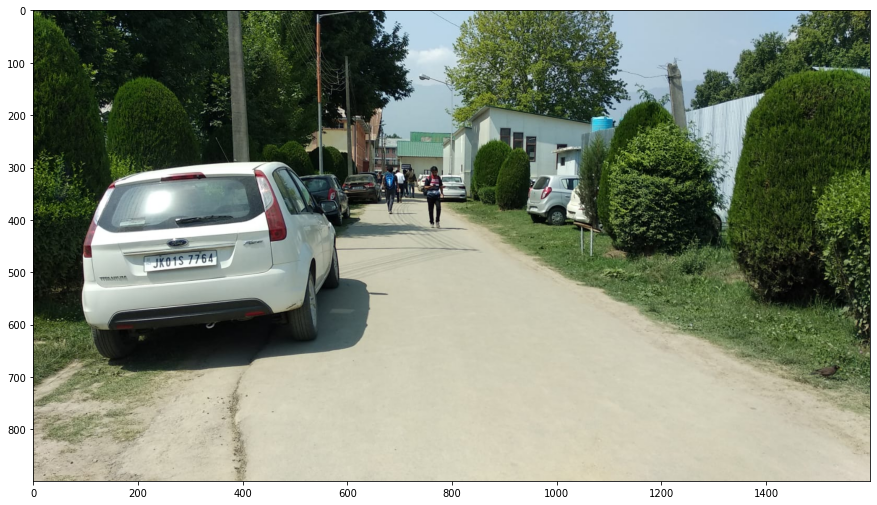

entered 0


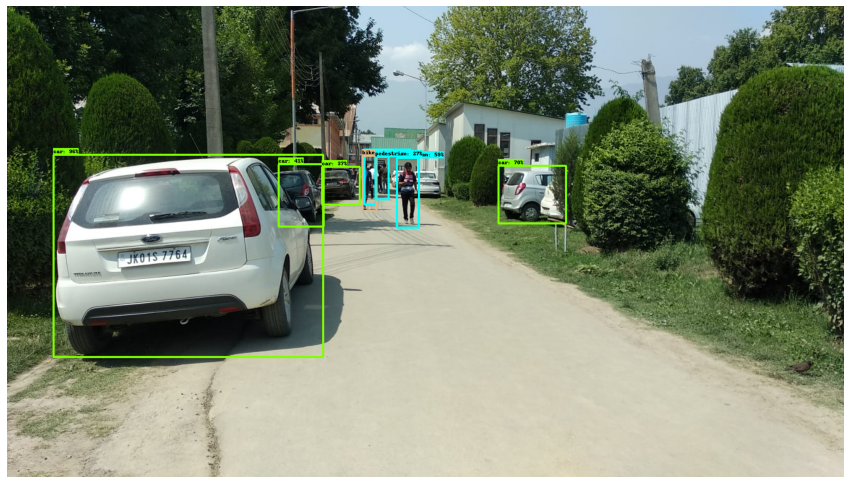

In [66]:
Image_Path = '../data/export/1478019958682197101_jpg.rf.XCoBnRWpmUTZFpYFGG3Y.jpeg'
test_img_path = '../data/test_imgs/campus_6.jpeg'
img_ = Image.open(test_img_path)

plt.figure(figsize=(15, 15))
plt.imshow(img_)
plt.show()

output_labels_, output_coods_ = pred_img(img_)